<a href="https://colab.research.google.com/github/Many98/real_estate/blob/criminality/notebooks/XGboost_v2_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 969 kB/s 


In [2]:
!pip uninstall xgboost
!pip install xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.8/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.6 MB 75 kB/s 


In [3]:
!pip install gpboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 11.8 MB/s 


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
#from gpboost import GPBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from category_encoders import TargetEncoder
from xgboost import plot_importance
from gpboost import plot_importance as gp_importance
#utils
from functools import partial

In [14]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('test_dataset.csv', sep=',', delimiter=None, encoding="utf8")
df2 = pd.read_csv('dataset.csv',sep=',', delimiter=None, encoding="utf8")

df.drop(columns=df.columns[0], axis=1, inplace=True) 

ok_cols = df.columns.difference(["note", "description", "hash", "name", "desc_hash", 
                                 "floor_area", "geometry", "place" ,"tags",
                                 "additional_disposition", "transport","header",
                                 "date"]+ [i for i in df.columns if '_txt' in i])

df = df[ok_cols]

df['price_m2'] = df["price"]/df["usable_area"]
df['gp'] = df['gp_mean_price'] * df["usable_area"]
df['price_diff'] = df['gp'] - df['price']
df['price_diff_m2'] = df['gp_mean_price'] - df['price_m2']

df = df[(df.price_m2 > 40000) & (df.price_m2 < 380000)]
df = df[(df.floor > -2) & (df.floor < 30)]


df2['price_m2'] = df2["price"]/df2["usable_area"]


df2 = df2[(df2.price_m2 > 40000) & (df2.price_m2 < 380000)]
df2 = df2[(df2.floor > -2) & (df2.floor < 30)]

for i in only_ord_dist:
  df2[i] = df[i]

df['city_district'] = df2['city_district']

df.dropna(how='any',subset=['city_district'], inplace=True)
df2.dropna(how='any',subset=['city_district'], inplace=True)
 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (367,385,388,389,391,392) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-14-89df9b374db7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_m2'] = df["price"]/df["usable_area"]
<ipython-input-14-89df9b374db7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gp'] = df['gp_mean_price'] * df["usable_area"]

# Exploratory analysis insigths

- `noise` is not very good predictor (high correlation) 

- most of `dist` features are within few metres
 which makes them not very useful

- on the other hand `subway_dist`, `tram_dist`, `train_dist` have non-trivial distribution and therefore I suggest to use only them from `dist` features

- in dataset are some "outliers" e.g. to low price per m2 -> this should be filtered

In [15]:
df2.groupby('disposition').describe()['price_m2']

,count,mean,std,min,25%,50%,75%,max
disposition,,,,,,,,
1+1,204.0,129579.081328,31309.959108,79761.904762,107671.568627,125320.512821,143450.000000,218181.818182
1+kk,1030.0,151339.092659,35253.065758,52368.421053,127521.551724,148483.258929,171602.163462,322008.571429
2+1,546.0,116366.263650,27645.635518,49985.714286,99667.874396,111046.296296,126929.104478,288800.000000
2+kk,2144.0,135603.768410,34030.618564,46718.750000,112464.622642,130698.051948,154599.567100,306636.363636
3+1,821.0,104722.670466,28047.548509,46066.666667,86721.311475,97560.963415,113200.000000,307758.620690
3+kk,1547.0,129629.330795,31702.278032,51510.416667,106935.509158,127819.548872,149689.800201,316952.380952
4+1,181.0,111789.232516,31770.173087,49038.461538,89600.000000,103333.333333,129555.555556,246679.577465
4+kk,571.0,132856.780723,37899.058733,46068.672619,104895.344288,130427.428571,156457.579537,272704.850467
5+1,29.0,118925.324588,25497.433757,82636.363636,102518.518519,113928.571429,132228.915663,186440.677966


In [16]:
df2.groupby('city_district').describe()['price_m2']

,count,mean,std,min,25%,50%,75%,max
city_district,,,,,,,,
Praha 1,212.0,187935.709541,45396.000336,88323.353293,153362.945736,185932.019704,218397.654846,336170.212766
Praha 10,547.0,121529.452926,31098.407210,45867.768595,99924.712644,115184.210526,138470.622120,217391.304348
Praha 11,293.0,118427.481586,30598.584786,59404.761905,94318.181818,110888.888889,140212.765957,221607.875000
Praha 12,283.0,114525.046379,23419.727076,57918.367347,97116.130820,110270.443396,132992.664474,174255.319149
Praha 13,318.0,120608.228343,33859.018288,55568.181818,95622.159091,113362.882800,145719.331845,223994.444444
Praha 14,216.0,111442.259230,25317.297438,49038.461538,94181.547619,107539.980010,131134.875135,193278.688525
Praha 15,445.0,139424.547666,32866.347894,47301.587302,112795.698925,148047.285714,163834.400000,205625.266667
Praha 16,13.0,125755.933892,14541.965458,93150.684932,125270.060241,128326.794872,133168.840909,146981.132075
Praha 17,76.0,104865.974220,16751.468226,77500.000000,91126.893939,101855.639098,116023.412948,145227.272727


In [17]:
encoder = TargetEncoder()

df[['construction_type_te', 
     'disposition_te',
    'energy_effeciency_te',
     'ownership_te',
     'state_te',
     'city_district_te',
     #'tram_station_dist_te',
     #'subway_station_dist_te',
     #'has_loggia_te',
     #'has_balcony_te',
     #'has_parking_te',
     #'has_garden_te',
     #'has_lift_te',
     #'has_cellar_te'
     ] + [i.replace('ord', 'te') for i in only_ord_dist]
    ]  = encoder.fit_transform(df2[['construction_type', 
     'disposition',
     'energy_effeciency',
     'ownership',
     'state',
     'city_district',
     #'tram_station_dist_ord',
     #'subway_station_dist_ord',
     #'has_loggia',
     #'has_balcony',
     #'has_parking',
     #'has_garden',
     #'has_lift',
     #'has_cellar'
     ]+ [i for i in only_ord_dist]], df2['price_m2'])

/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [18]:
# columns with embeddings
only_embeddings = [i for i in df.columns if 'emb' in i]

# only ordinal columns 
only_ord = [i for i in df.columns if 'ord' in i]

# columns with ordinal distance
only_ord_dist = [i for i in df.columns if 'dist' in i and 'ord' in i 
                 and 'num' not in i and 'city' not in i and '_te' not in i]

# only numerical dist columns (with indicator >=1500m)
only_num_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and 'num' in i and 'city' not in i] + \
                [i for i in df.columns if '1500m' in i and '_te' not in i]


# only one-hot encoded distances
only_one_hot_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and
                     'num' not in i and 'city' not in i and '_te' not in i]
only_one_hot_100m = [i for i in df.columns if '0-99m' in i and '_te' not in i]

only_te_dist = [i for i in df.columns if 'dist' in i and '_te' in i]

# only coordinates
only_coords = ['long', 'lat']

# Gaussian process predicition
only_gp = [i for i in df.columns if 'gp' in i]

# noise
only_noise = [i for i in df.columns if 'noise' in i]

# quality
only_quality_ord = [i for i in df.columns if ('quality' in i or
                'sun' in i or 'built' in i) and 'ord' in i]

# one hotncoded energy effeciency
only_energy = [i for i in df.columns if 'energy_effeciency' in i and 'ord' not in i
               and '_te' not in i]


# disposition
only_disposition = [i for i in df.columns if 'disposition' in i and '_te' not in i]

# construction_type
only_construction = [i for i in df.columns if 'construction_t' in i and '_te' not in i]

# ownership
only_ownership = [i for i in df.columns if 'ownership' in i and '_te' not in i]

# equipment
only_equipment = [i for i in df.columns if 'equipment' in i]

# state
only_state = [i for i in df.columns if 'state' in i and '_te' not in i]

# only has_<> features
only_has = [i for i in df.columns if 'has' in i and '_te' not in i]

# only target encoded features

only_te = [i for i in df.columns if '_te' in i]

In [19]:
df2.columns

Index(['city_district', 'additional_disposition', 'air_quality', 'atm_dist',
       'built_density', 'bus_station_dist', 'construction_type', 'daily_noise',
       'date', 'desc_hash', 'description', 'disposition', 'doctor_dist',
       'electricity', 'electricity_txt', 'energy_effeciency', 'equipment',
       'floor', 'floor_area', 'gas', 'geometry', 'gp_ci_high_price',
       'gp_ci_low_price', 'gp_mean_price', 'gp_std_price', 'has_balcony',
       'has_cellar', 'has_garage', 'has_garden', 'has_lift', 'has_loggia',
       'has_parking', 'hash', 'header', 'heating', 'heating_txt',
       'kindergarten_dist', 'lat', 'long', 'name', 'nightly_noise',
       'no_barriers', 'note', 'ownership', 'pharmacy_dist', 'place',
       'playground_dist', 'post_office_dist', 'price', 'primary_school_dist',
       'restaurant_pub_dist', 'sports_field_dist', 'state',
       'subway_station_dist', 'sun_glare', 'supermarket_grocery_dist', 'tags',
       'telecomunication', 'telecomunication_txt', 'theat

In [20]:
print(only_embeddings)
print(only_ord)
print(only_ord_dist)
print(only_num_dist)
print(only_one_hot_dist)
print(only_gp)
print(only_noise)
print(only_quality_ord)
print(only_disposition)
print(only_ownership)
print(only_energy)
print(only_has)
print(only_one_hot_100m)
print(only_te)
print(only_te_dist)

# e.g. when u want columns without embeddings and without ordinal features and without
#one-hot encoded ditances do something like that

df1 = df[df.columns.difference(only_embeddings + only_ord + only_one_hot_dist)]

['ft_emb_1', 'ft_emb_10', 'ft_emb_100', 'ft_emb_101', 'ft_emb_102', 'ft_emb_103', 'ft_emb_104', 'ft_emb_105', 'ft_emb_106', 'ft_emb_107', 'ft_emb_108', 'ft_emb_109', 'ft_emb_11', 'ft_emb_110', 'ft_emb_111', 'ft_emb_112', 'ft_emb_113', 'ft_emb_114', 'ft_emb_115', 'ft_emb_116', 'ft_emb_117', 'ft_emb_118', 'ft_emb_119', 'ft_emb_12', 'ft_emb_120', 'ft_emb_121', 'ft_emb_122', 'ft_emb_123', 'ft_emb_124', 'ft_emb_125', 'ft_emb_126', 'ft_emb_127', 'ft_emb_128', 'ft_emb_129', 'ft_emb_13', 'ft_emb_130', 'ft_emb_131', 'ft_emb_132', 'ft_emb_133', 'ft_emb_134', 'ft_emb_135', 'ft_emb_136', 'ft_emb_137', 'ft_emb_138', 'ft_emb_139', 'ft_emb_14', 'ft_emb_140', 'ft_emb_141', 'ft_emb_142', 'ft_emb_143', 'ft_emb_144', 'ft_emb_145', 'ft_emb_146', 'ft_emb_147', 'ft_emb_148', 'ft_emb_149', 'ft_emb_15', 'ft_emb_150', 'ft_emb_151', 'ft_emb_152', 'ft_emb_153', 'ft_emb_154', 'ft_emb_155', 'ft_emb_156', 'ft_emb_157', 'ft_emb_158', 'ft_emb_159', 'ft_emb_16', 'ft_emb_160', 'ft_emb_161', 'ft_emb_162', 'ft_emb_163', 

In [21]:
df_final = df[['price', 'usable_area', 'price_m2', 'price_diff', 'price_diff_m2',
               #'year_reconstruction_ord',
               'floor', 
              #'construction_type_te', 
              #'disposition_te',
              #'energy_effeciency_te',
              #'ownership_te',
              #'state_te',
              #'city_district_te',
              #'tram_station_dist_te',
              #'subway_station_dist_te',
              #'has_loggia_te',
              #'has_balcony_te',
              #'has_parking_te',
              #'has_garden_te',
              #'has_lift_te',
              #'has_cellar_te',
              #'tram_station_dist_ord',
              # 'subway_station_dist_ord
               
               ]
              +only_gp
              +only_coords
              #+only_one_hot_dist
              #+only_energy
              #+only_disposition
              #+only_ownership
              #+only_state
              #+only_equipment
              #+only_noise
              +only_te
              #+only_te_dist
              #+only_construction
              #+only_one_hot_100m
              #+only_num_dist
              #+only_ord_dist
              +only_has
              #+only_embeddings
              ].copy()  # here set final df

#df_final = df_final[(df_final.price_m2 < 380000)]


df_final.columns = df_final.columns.str.replace(r'.', '_')
df_final.columns = df_final.columns.str.replace(r'-', '_')
df_final.columns = df_final.columns.str.replace(r'>=', '_vetsi_rovno_')
df_final.columns = df_final.columns.str.replace(r'+', '_plus_')
df_final.columns = df_final.columns.str.replace(r' ', '_')
df_final.columns = df_final.columns.str.replace(r'/', '_')
df_final.columns = df_final.columns.str.replace(r'[', '_')
df_final.columns = df_final.columns.str.replace(r']', '_')
df_final.columns = df_final.columns.str.replace(r'<', 'mensi')

df_final.columns

<ipython-input-21-b4300ead4c98>:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final.columns = df_final.columns.str.replace(r'.', '_')
<ipython-input-21-b4300ead4c98>:47: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final.columns = df_final.columns.str.replace(r'+', '_plus_')
<ipython-input-21-b4300ead4c98>:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final.columns = df_final.columns.str.replace(r'[', '_')
<ipython-input-21-b4300ead4c98>:51: FutureWarning: The default value of regex will change from Tru

Index(['price', 'usable_area', 'price_m2', 'price_diff', 'price_diff_m2',
       'floor', 'gp_ci_high_price', 'gp_ci_low_price', 'gp_mean_price',
       'gp_std_price', 'gp', 'long', 'lat', 'construction_type_te',
       'disposition_te', 'energy_effeciency_te', 'ownership_te', 'state_te',
       'city_district_te', 'atm_dist_te', 'bus_station_dist_te',
       'doctor_dist_te', 'kindergarten_dist_te', 'park_dist_te',
       'pharmacy_dist_te', 'playground_dist_te', 'post_office_dist_te',
       'primary_school_dist_te', 'restaurant_pub_dist_te',
       'sports_field_dist_te', 'subway_station_dist_te',
       'supermarket_grocery_dist_te', 'theatre_cinema_dist_te',
       'train_station_dist_te', 'tram_station_dist_te', 'vet_dist_te',
       'has_balcony', 'has_cellar', 'has_garage', 'has_garden', 'has_lift',
       'has_loggia', 'has_parking'],
      dtype='object')

In [22]:
only_te

['construction_type_te',
 'disposition_te',
 'energy_effeciency_te',
 'ownership_te',
 'state_te',
 'city_district_te',
 'atm_dist_te',
 'bus_station_dist_te',
 'doctor_dist_te',
 'kindergarten_dist_te',
 'park_dist_te',
 'pharmacy_dist_te',
 'playground_dist_te',
 'post_office_dist_te',
 'primary_school_dist_te',
 'restaurant_pub_dist_te',
 'sports_field_dist_te',
 'subway_station_dist_te',
 'supermarket_grocery_dist_te',
 'theatre_cinema_dist_te',
 'train_station_dist_te',
 'tram_station_dist_te',
 'vet_dist_te']

In [23]:
df_final = df_final[set(df_final.columns)]

In [24]:
#on

In [25]:
df_final.columns

Index(['gp_ci_high_price', 'gp_mean_price', 'supermarket_grocery_dist_te',
       'state_te', 'primary_school_dist_te', 'theatre_cinema_dist_te',
       'price_m2', 'pharmacy_dist_te', 'city_district_te', 'gp_std_price',
       'construction_type_te', 'bus_station_dist_te', 'sports_field_dist_te',
       'has_parking', 'price_diff', 'has_balcony', 'has_cellar',
       'post_office_dist_te', 'has_loggia', 'has_garage', 'playground_dist_te',
       'usable_area', 'floor', 'gp_ci_low_price', 'lat',
       'energy_effeciency_te', 'park_dist_te', 'has_lift', 'price',
       'has_garden', 'train_station_dist_te', 'tram_station_dist_te',
       'atm_dist_te', 'kindergarten_dist_te', 'disposition_te',
       'price_diff_m2', 'restaurant_pub_dist_te', 'gp', 'vet_dist_te',
       'doctor_dist_te', 'long', 'ownership_te', 'subway_station_dist_te'],
      dtype='object')

In [19]:
# df_final['daily_noise'] = df_final['daily_noise'].replace(0, 50)
# df_final['nightly_noise'] = df_final['nightly_noise'].replace(0, 50)

In [26]:
y = df_final[['price', 'price_m2', 'price_diff' ,'price_diff_m2']]

X = df_final[df_final.columns.difference(['price', 'price_m2',
                                          #'gp',
                                          'price_diff', 'price_diff_m2'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, shuffle=True)

In [27]:
X_train

,atm_dist_te,bus_station_dist_te,city_district_te,construction_type_te,disposition_te,doctor_dist_te,energy_effeciency_te,floor,gp,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,has_balcony,has_cellar,has_garage,has_garden,has_lift,has_loggia,has_parking,kindergarten_dist_te,lat,long,ownership_te,park_dist_te,pharmacy_dist_te,playground_dist_te,post_office_dist_te,primary_school_dist_te,restaurant_pub_dist_te,sports_field_dist_te,state_te,subway_station_dist_te,supermarket_grocery_dist_te,theatre_cinema_dist_te,train_station_dist_te,tram_station_dist_te,usable_area,vet_dist_te
122,7,3,139335.262910,148778.128127,132856.780723,14,128130.678738,6.0,1.536067e+07,188632.251604,63181.948084,125907.099844,31362.575880,False,True,False,False,False,False,True,7,50.054346,14.408974,133345.218782,7,10,5,10,8,4,3,135619.528932,6,7,16,7,5,122.0,10
481,6,1,111442.259230,102941.532821,111789.232516,7,128130.678738,5.0,9.962375e+06,173086.059115,48300.057867,110693.058491,31196.500312,False,False,False,False,False,False,False,2,50.102974,14.564260,133345.218782,2,6,2,6,1,6,4,112516.227810,6,2,16,16,13,90.0,7
5028,10,2,119207.256838,135539.244823,135603.768410,13,119352.932628,3.0,1.040115e+07,178111.127270,53025.600113,115568.363691,31271.381789,True,True,True,False,False,False,True,6,50.041378,14.424052,133345.218782,3,10,3,11,2,4,2,126022.393676,16,9,7,16,10,90.0,10
2581,5,1,114525.046379,102941.532821,151339.092659,6,116853.682567,1.0,3.836755e+06,171715.571444,47527.588856,109621.580150,31046.995647,False,True,False,False,True,True,False,5,50.018298,14.437281,99800.711029,7,4,1,8,3,4,2,126022.393676,16,1,8,16,15,35.0,2
294,4,2,121529.452926,135539.244823,135603.768410,13,116853.682567,6.0,8.197275e+06,179122.909964,55084.933740,117103.921852,31009.494056,True,True,False,False,False,False,False,3,50.053177,14.513111,133345.218782,8,3,2,4,5,2,5,126022.393676,16,5,11,12,4,70.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3780,2,1,124372.606472,135539.244823,132856.780723,7,116853.682567,4.0,1.595676e+07,189675.584665,65632.522080,127654.053372,31010.765646,False,True,True,False,True,False,False,5,50.122749,14.454110,133345.218782,2,3,6,6,2,1,3,135619.528932,2,2,3,16,2,125.0,4
5205,7,2,111442.259230,135539.244823,142949.152169,2,128130.678738,3.0,1.231892e+07,176710.156727,51417.949264,114064.052995,31323.051866,True,False,False,False,True,False,True,6,50.102588,14.556298,133345.218782,6,2,3,4,4,4,4,135619.528932,6,5,16,11,8,108.0,7
5240,4,1,139424.547666,148778.128127,135603.768410,7,146218.732753,3.0,5.534711e+06,175490.211749,50416.361549,112953.286649,31268.462550,True,True,False,False,False,False,True,3,50.045000,14.523182,133345.218782,16,5,2,5,5,3,4,156233.750194,16,2,16,8,16,49.0,1
5404,1,6,121529.452926,135539.244823,135603.768410,6,116853.682567,3.0,3.909628e+06,196646.466104,72983.081138,134814.773621,30915.846241,False,False,False,False,True,False,False,1,50.069830,14.450086,133345.218782,2,7,2,5,2,3,3,132887.257638,9,5,4,6,2,29.0,3


# GPBoost
https://gpboost.readthedocs.io/en/latest/pythonapi/gpboost.GPBoostRegressor.html#gpboost.GPBoostRegressor

In [ ]:
model = GPBoostRegressor(n_estimators = 1500,
                         boosting_type= 'dart',#'gbdt',
                     learning_rate=0.08999, 
                     colsample_bytree=0.96,
                     colsample_bynode=1,
                     #objective='reg:squarederror',
                     #eval_metric=mean_absolute_error,
                     max_depth=3,
                     #tree_method='hist',
                     #enable_categorical=True,
                     #subsample=0.9,
                     random_state=42, silent=True, 
                     #booster='gbtree',
                     
            early_stopping_rounds=20)
response = 'price_diff_m2'
model.fit(X_train, y_train[response], eval_set=[(X_test, y_test[response])])

# make predictions for test data
y_pred = model.predict(X_test)
y_pred2 = model.predict(X_train)

#y_pred2 = X_test['usable_area'] * y_pred

import numpy as np
print("The model training score is " , model.score(X_train, y_train[response]))
print("The model testing score is " , model.score(X_test, y_test[response]))
print("The model train mean absolute error is ", mean_absolute_error(y_train[response], y_pred2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test[response], y_pred))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train[response], y_pred2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test[response], y_pred)))
print("The model max error is ", max_error(y_test[response], y_pred))
print("The model median absolute error is ", median_absolute_error(y_test[response], y_pred))

/usr/local/lib/python3.8/dist-packages/gpboost/engine.py:185: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.8/dist-packages/gpboost/callback.py:182: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[GPBoost] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's l2: 9.83979e+08
[2]	valid_0's l2: 9.4074e+08
[3]	valid_0's l2: 9.00753e+08
[4]	valid_0's l2: 8.69429e+08
[5]	valid_0's l2: 8.41554e+08
[6]	valid_0's l2: 8.11218e+08
[7]	valid_0's l2: 8.13856e+08
[8]	valid_0's l2: 7.91845e+08
[9]	valid_0's l2: 7.71899e+08
[10]	valid_0's l2: 7.75683e+08
[11]	valid_0's l2: 7.58974e+08
[12]	valid_0's l2: 7.6357e+08
[13]	valid_0's l2: 7.4898e+08
[14]	valid_0's l2: 7.32496e+08
[15]	valid_0's l2: 7.16496e+08
[16]	valid_0's l2: 7.00813e+08
[17]	valid_0's l2: 7.06934e+08
[18]	valid_0's l2: 6.95853e+08
[19]	valid_0's l2: 6.96593e+08
[20]	valid_0's l2: 6.973e+08
[21]	valid_0's l2: 7.03266e+08
[22]	valid_0's l2: 7.17248e+08
[23]	valid_0's l2: 7.03685e+08
[24]	valid_0's l2: 7.16315e+08
[25]	valid_0's l2: 7.15081e+08
[26]	valid_0's l2: 7.04285e+08
[27]	valid_0's l2: 6.92384e+08
[28]	valid_0's l2: 6.95392e+08
[29]	valid_0'

In [ ]:
ax = gp_importance(model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

In [ ]:
only_gp[:-1]

# Gaussian process

In [ ]:
gp = GaussianProcessRegressor(kernel= Matern(length_scale=0.1, nu=0.01),
                              normalize_y= True)
gp.fit(X_train[['long', 'lat']], y_train['price_m2'])

In [ ]:
gp_predicted = gp.predict(X_test[['long', 'lat']])
gp_predicted2 = gp.predict(X_test[['long', 'lat']])
import numpy as np

response = 'price_m2'
print("The model training score is " , gp.score(X_train, y_train[response]))
print("The model testing score is " , gp.score(X_test, y_test[response]))
print("The model train mean absolute error is ", mean_absolute_error(y_train[response], gp_predicted2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test[response], gp_predicted))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train[response], gp_predicted2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test[response], gp_predicted)))
print("The model max error is ", max_error(y_test[response], gp_predicted))
print("The model median absolute error is ", median_absolute_error(y_test[response],gp_predicted))

# XGBOOST

In [28]:
# squared_error  
# TODO it uses squared error we need to use absolute error but colab does not have it

response = 'price'

mean = y_train[response].mean()
std = y_train[response].std()

y_train['response'] = (y_train[response] - mean) / std
y_test['response'] = (y_test[response] - mean) / std

model = XGBRegressor(n_estimators = 1500,
                     learning_rate=0.08999, 
                     colsample_bytree=0.99,
                     colsample_bynode=0.60,
                     objective='reg:squarederror',#'reg:pseudohubererror',
                     eval_metric=mean_absolute_error,
                     max_depth=4,
                     tree_method='hist',
                     enable_categorical=True,
                     #subsample=0.9,
                     random_state=42, silent=True, booster='gbtree',
                     early_stopping_rounds=20)
X_train = X_train.astype(float)
X_test = X_test.astype(float)


model.fit(X_train, y_train['response'], eval_set=[(X_test, y_test['response'])])

# make predictions for test data
y_pred = model.predict(X_test)
y_pred2 = model.predict(X_train)

#y_pred2 = X_test['usable_area'] * y_pred

print("The model training score is " , model.score(X_train, y_train['response']))
print("The model testing score is " , model.score(X_test, y_test['response']))
print("The model train mean absolute error is ", mean_absolute_error(y_train['response'], y_pred2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test['response'], y_pred))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train['response'], y_pred2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test['response'], y_pred)))
print("The model max error is ", max_error(y_test['response'], y_pred))
print("The model median absolute error is ", median_absolute_error(y_test['response'], y_pred))

[13:45:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:1.04225	validation_0-mean_absolute_error:0.82648
[1]	validation_0-rmse:0.96893	validation_0-mean_absolute_error:0.76228
[2]	validation_0-rmse:0.90202	validation_0-mean_absolute_error:0.70479
[3]	validation_0-rmse:0.84482	validation_0-mean_absolute_error:0.65298
[4]	validation_0-rmse:0.79328	validation_0-mean_absolute_error:0.60715
[5]	validation_0-rmse:0.74774	validation_0-mean_absolute_error:0.56687
[6]	validation_0-rmse:0.70387	validation_0-mean_absolute_error:0.53052
[7]	validation_0-rmse:0.66562	validation_0-mean_absolute_error:0.49753
[8]	validation_0-rmse:0.63626	validation_0-mean_absolute_error:0.46911
[9]	validation_0-rmse:0.61020	validation_0-mean_absolute_error:0.44254
[10]	validation_0-rmse:0.58240	validation_0-mean_absolute_error:0.41948
[11]	validation_0-rmse:0.56342	validation_0-mean_absolute_error:0.39980
[12]	validation_0-rmse:0.54434	validation_0-mean_absolute_erro

In [29]:
yy = (y_pred * std) + mean
print(mean_absolute_error(y_test['price'], yy))

1108961.5326388888


## SHAP part

In [25]:
y = df_final['price']

X = df_final[df_final.columns.difference(['price', 'price_m2',
                                          #'gp',
                                          'price_diff', 'price_diff_m2'])]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = 42)

In [30]:
!pip install shap -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.2 MB/s 


In [31]:
import time
import shap

In [ ]:
shap.initjs()

Zde manipulovat mnozstvim samplu aby se "projevil" vliv promennych globalne

In [42]:
X_sampled = X_test.sample(1, random_state=2)

In [43]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

In [ ]:
# Crashes the session
#shap.force_plot(explainer.expected_value, shap_values, X_train)

In [44]:
X_sampled

,atm_dist_te,bus_station_dist_te,city_district_te,construction_type_te,disposition_te,doctor_dist_te,energy_effeciency_te,floor,gp,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,has_balcony,has_cellar,has_garage,has_garden,has_lift,has_loggia,has_parking,kindergarten_dist_te,lat,long,ownership_te,park_dist_te,pharmacy_dist_te,playground_dist_te,post_office_dist_te,primary_school_dist_te,restaurant_pub_dist_te,sports_field_dist_te,state_te,subway_station_dist_te,supermarket_grocery_dist_te,theatre_cinema_dist_te,train_station_dist_te,tram_station_dist_te,usable_area,vet_dist_te
349,4.0,2.0,119207.256838,135539.244823,129629.330795,5.0,116853.682567,2.0,1.330515e+07,188708.352544,64723.076305,126715.714424,30996.31906,0.0,1.0,0.0,0.0,1.0,1.0,1.0,5.0,50.061922,14.446781,133345.218782,4.0,5.0,4.0,7.0,3.0,1.0,5.0,126022.393676,11.0,1.0,5.0,4.0,1.0,105.0,2.0


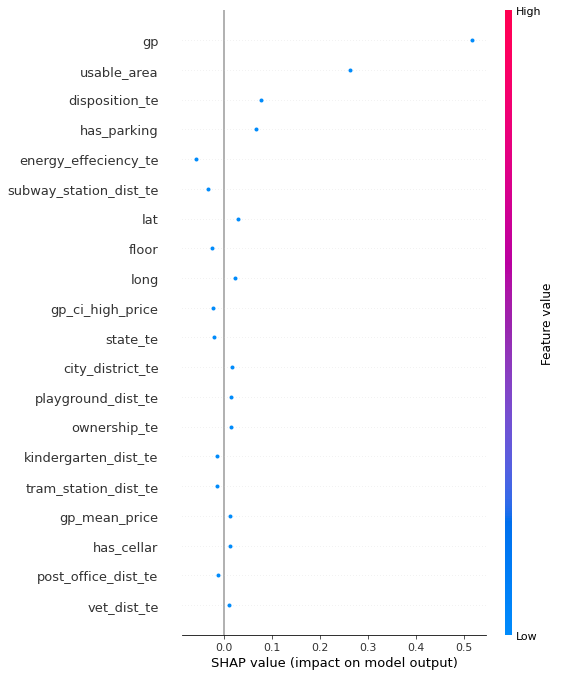

In [45]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

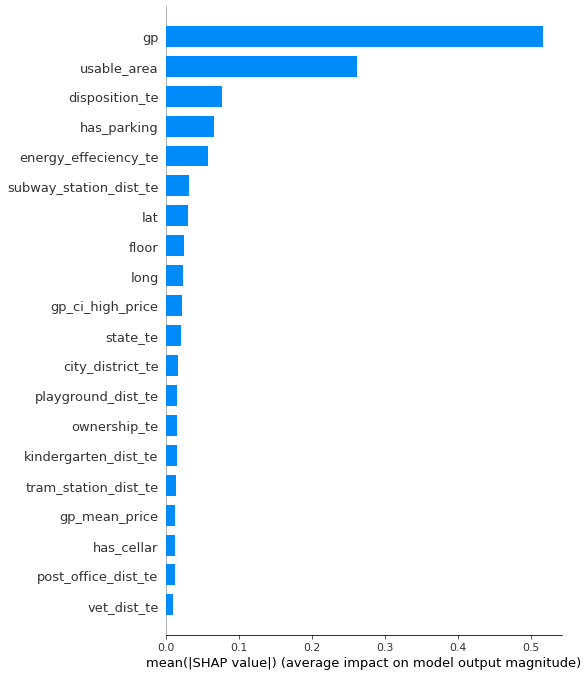

In [46]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [123]:
shap_values

array([[ 4.34405282e-02, -1.99127853e-01, -6.06043525e-02,
        -4.12758952e-03,  3.82215157e-02,  3.75721082e-02,
         3.29080485e-02,  6.55991212e-03, -1.36002107e-02,
        -8.22643706e-05,  1.15976455e-02,  9.07034706e-03,
         1.12744860e-01,  8.94573554e-02,  1.25845313e-01,
        -1.21748000e-02]], dtype=float32)

In [124]:
np.sum(shap_values)

0.21770053

In [47]:
shpv = shap_values.squeeze()

In [48]:
from random import randint
color = []
n = 16
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

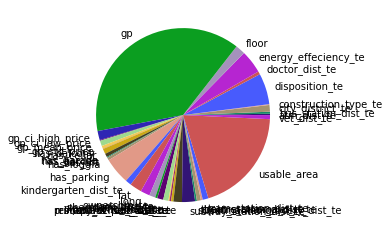

In [49]:
plt.pie(np.abs(shpv)/np.sum(shpv), labels=X_sampled.columns, colors= color)
plt.show()

# TODO perform quantile regression

- https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b

- https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

- https://gist.github.com/Nikolay-Lysenko/06769d701c1d9c9acb9a66f2f9d7a6c7

- https://colab.research.google.com/github/benoitdescamps/benoit-descamps-blogs/blob/master/notebooks/quantile_xgb/xgboost_quantile_regression.ipynb#scrollTo=Rb4sKEKa9EkN